# QNN

In [1]:
from qutip import *
from qutip.measurement import measure, measurement_statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import time
import random
from tqdm.notebook import tqdm

In [2]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    if isket(rho):  # ket状態を密度関数にする（必要かわからん）
        rho = ket2dm(rho)
    
    scale = np.sqrt(2)
    xvec = np.linspace(-5*scale,5*scale,100)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec/scale, xvec/scale, W, 60, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel('q', fontsize=16)
    ax.set_ylabel('p', fontsize=16)
    ax.axis("off")
    #ax.set_title()
    fig.tight_layout
    
    return fig, ax

phase rotation、kerr演算子を定義

In [3]:
def rotation(dim, phi):
    a = destroy(dim)
    op = 1j * phi * a.dag() * a
    return op.expm()

def kerr(dim, kappa):
    a = destroy(dim)
    n = a.dag() * a
    op = 1j * kappa * n * n
    return op.expm()

まずは1-moodeのQNNを構成する

In [12]:
def variational_quantum_circuit(params):
    # Gate layer: D-R-S-R-K
    def layer(i, phi):
        D = displace(dim, params[i*7+0]*np.exp(1j*params[i*7+1]))
        R1 = rotation(dim, params[i*7+2])
        S = squeeze(dim, params[i*7+3]*np.exp(1j*params[i*7+4]))
        R2 = rotation(dim, params[i*7+5])
        K = kerr(dim, params[i*7+6])
        quantum_state = K * D * R2 * S * R1 * phi
        return quantum_state
    
    # construct the circuit
    state = fock(dim, 0)
    for i in range(depth):
        state = layer(i, state)
    return state

cost関数を定義。ここでは以下の関数とする。

$C(\theta) = |1-\langle \Psi_{t}|U(\theta)|0\rangle|$

In [13]:
def cost(target_state, ket): # target_stateとketはQobjを想定している
    # 規格化
    target_norm = target_state.unit()
    ket_norm = ket.unit()
    
    # fidelityを計算
    fidelity = target_norm.dag() * ket_norm
    return abs(1-fidelity[0,0])

Loss関数の勾配を計算する関数を定義

In [14]:
def get_cost_gradient(params):
    eps = 0.001
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        state_plus = variational_quantum_circuit(tmp_params)
        cost_plus = cost(target_state, state_plus)
        #print("cost plus", cost_plus)
        tmp_params[i] -= 2*eps
        state_minus = variational_quantum_circuit(tmp_params)
        cost_minus = cost(target_state, state_minus)
        #print("cost minus", cost_minus)
        #print((cost_plus-cost_minus)/2/eps)
        grad_vector[i] = (cost_plus-cost_minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

In [15]:
def Adam(params, rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-07, steps=100):
    m_0 = 0
    v_0 = 0
    tmp_params = np.copy(params)
    params_history = []
    params_history.append(np.copy(tmp_params))
    for i in tqdm(range(steps)):
        grad = get_cost_gradient(tmp_params)
        m_0 = beta1 * m_0 + (1 - beta1) * grad
        v_0 = beta2 * v_0 + (1 - beta2) * grad * grad
        m = m_0 / (1 - beta1)
        v = v_0 / (1 - beta2)
        tmp_params -= rate * m / np.sqrt(v + epsilon)
        params_history.append(np.copy(tmp_params))
        
    return tmp_params, params_history

In [16]:
def GD(params, rate=0.1, steps=100):
    tmp_params = np.copy(params)
    params_history = []
    params_history.append(np.copy(tmp_params))
    for i in tqdm(range(steps)):
        grad = get_cost_gradient(tmp_params)
        tmp_params -= rate * grad
        params_history.append(np.copy(tmp_params))
        
    return tmp_params, params_history

ターゲットとして|1>を使う

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='q', ylabel='p'>)

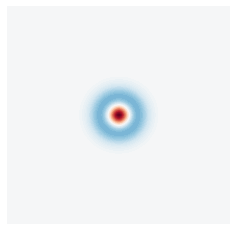

In [17]:
dim = 30
target_state = fock(dim, 1)
'''
coef = np.array([ 6.04477662e-01+0.j,  1.05906864e-19+0.j, -3.17223422e-01+0.j,
  2.72724753e-18+0.j,  3.96119278e-01+0.j,  3.70720754e-18+0.j,
  1.61022510e-01+0.j, -2.76015996e-18+0.j,  5.27438226e-01+0.j,
  3.99567421e-18+0.j, -2.18445912e-02+0.j, -2.74085362e-18+0.j,
 -1.01435222e-01+0.j, -4.97127245e-20+0.j, -1.19296536e-01+0.j,
 -2.15649464e-18+0.j,  1.75645600e-01+0.j,  1.07210072e-19+0.j,
 -5.15033890e-02+0.j,  2.83972315e-18+0.j, -1.93046730e-02+0.j,
 -4.32914783e-19+0.j,  4.47480409e-02+0.j,  1.03633778e-18+0.j,
  6.86602831e-02+0.j, -4.46030929e-19+0.j, -1.98268436e-03+0.j,
 -4.56557191e-20+0.j,  8.57384984e-02+0.j,  2.97560174e-18+0.j])
target_state = 0 * fock(dim, 0)
for i in range(dim):
    target_state += coef[i] * fock(dim, i)
'''
plot_wigner(target_state)

最適化を行う

  0%|          | 0/100 [00:00<?, ?it/s]

time 424.95188999176025 s


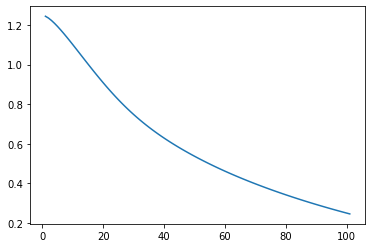

In [18]:
depth = 8

# 学習
params = np.random.normal(0, 0.1, [7*depth]) # 最初のパラメータ
steps = 100
rate = 0.001

start = time.time()
learnt_params, params_history = Adam(params, rate=rate, steps=steps)
end = time.time()
# save history
cost_history = []
state_history = []
for i in range(len(params_history)):
    learnt_state = variational_quantum_circuit(params_history[i])
    C = cost(target_state, learnt_state)
    cost_history.append(C)
    if i % (steps / 100) == 0:
        state_history.append(learnt_state)

print('time', end - start, 's')
plt.plot(np.linspace(1, steps+1, steps+1), cost_history)
plt.show()

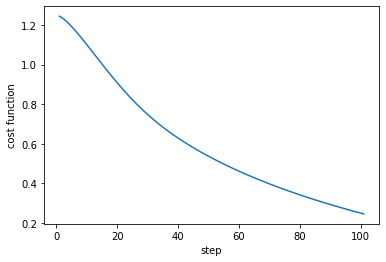

100 0.5683275170157118


In [21]:
plt.plot(np.linspace(1, steps+1, steps+1), cost_history)
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()
cost_history_np = np.array(cost_history)
fid = (1-cost_history_np.min())**2
amin = cost_history_np.argmin()
print(amin, fid)

In [ ]:
for i in range(len(state_history)):
    plot_wigner(state_history[i])

In [ ]:
# save data
cost_history_np = np.array(cost_history)
params_history_np = np.array(params_history)
optname = '_adam'
statename = '_gkp0.1'
cpuname = 'intel_core_i7_11gen'
savename = 'd'+str(depth)+'_step'+str(steps)+optname+'_rate'+str(rate)+'_eps0.001_'
np.save(savename+'cost'+statename, cost_history_np)
np.save(savename+'params'+statename, params_history_np)
fid = (1-cost_history_np.min())**2
amin = cost_history_np.argmin()
f = open(savename+'.txt', 'a')
f.write('\n')
if steps > 1000:
    datalist = ['CPU: '+cpuname+'\n', savename+statename+'\n', 'Cutoff dimention: '+str(dim)+'\n',
                'Runtime: '+str(end-start)+'s\n', 'Fidelity: '+str(fid)+'\n', 'argmin: '+str(amin)+'\n',
                'Fidelity1000: '+str((1-cost_history_np[1000])**2)+'\n']
else:
    datalist = ['CPU: '+cpuname+'\n', savename+statename+'\n', 'Cutoff dimention: '+str(dim)+'\n', 
                'Runtime: '+str(end-start)+'s\n', 'Fidelity: '+str(fid)+'\n', 'argmin: '+str(amin)+'\n']
f.writelines(datalist)
f.close()
print(amin, fid)
print(savename)

4000 0.9935959974036861


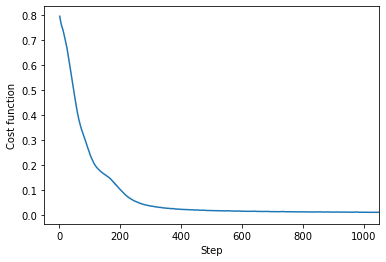

In [46]:
co = np.load('d8_step4000_adam_rate0.001_eps0.001_cost_d_cat.npy')
print(co.argmin(), (1-co[3999])**2)
plt.plot(np.linspace(1, len(co), len(co)), co)
plt.xlim([-50,1050])
plt.xlabel('Step')
plt.ylabel('Cost function')
plt.show()

5001


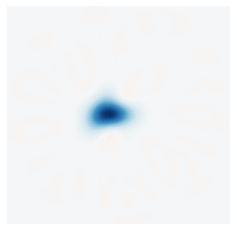

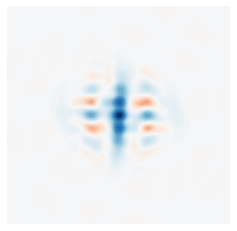

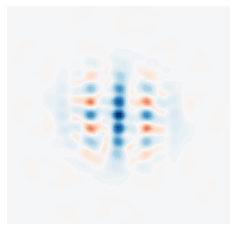

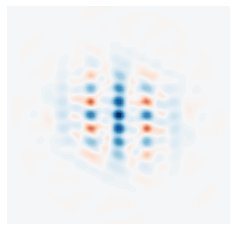

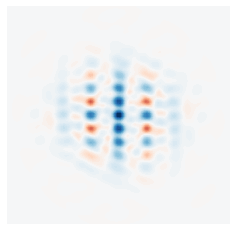

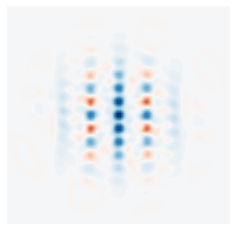

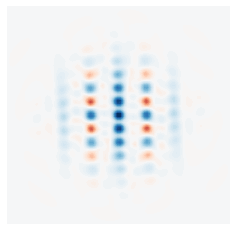

In [72]:
depth = 10
dim = 30
par = np.load('d10_step5000_adam_rate0.001_eps0.001_params_gkp0.1.npy')
print(len(par))
plot_list = [0, 70, 120, 200, 350, 1000, 3999]

for i in plot_list:
    sta = variational_quantum_circuit(par[i])
    plot_wigner(sta)